Galaxy selected: NGC_3034 
Number of data points: 74

Statistics for Radius (kpc):
Mean: 1.87
Median: 1.88
Std Dev: 1.07
Min: 0.05
Max: 3.70
Skewness: 0.00
Kurtosis: -1.20

Statistics for Velocity (km/s):
Mean: 116.24
Median: 104.67
Std Dev: 48.52
Min: 56.09
Max: 201.69
Skewness: 0.31
Kurtosis: -1.26


Enter number of terms for polynomial model (2-10, default=3):  5



Fitting models...
Physical fit error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.
Basic NFW fit failed: Method 'lm' only works for unconstrained problems. Use 'trf' or 'dogbox' instead.
Full NFW fit failed: `x0` is infeasible.
Trying genetic algorithm...

Metrics for Polynomial Model:
R²: 0.9718
RMSE: 8.15 km/s
MSE: 66.34

Metrics for NFW Model:
R²: 0.5984
RMSE: 30.74 km/s
MSE: 945.22

Metrics for Isothermal Model:
R²: -0.4191
RMSE: 57.80 km/s
MSE: 3340.44
Polynomial Model - AIC: 320.4, BIC: 331.9
NFW Model - AIC: 515.0, BIC: 524.2
Isothermal Model - AIC: 604.4, BIC: 609.0

 NFW Parameters:
ρ_s = 8.78e+09 M☉/kpc³
r_s = 0.49 kpc
v0 = 3.93 km/s
α = 0.50

Isothermal Density: ρ_0 = 2.72e+10 M☉/kpc³ (r_c = 0.10 kpc)

Physical model coefficients and contributions:
c_(-1) = -2.1940e+09  [linear r term] → 23.1% contribution
c_0    = 1.0740e+10  [constant term] → 58.4% contributio

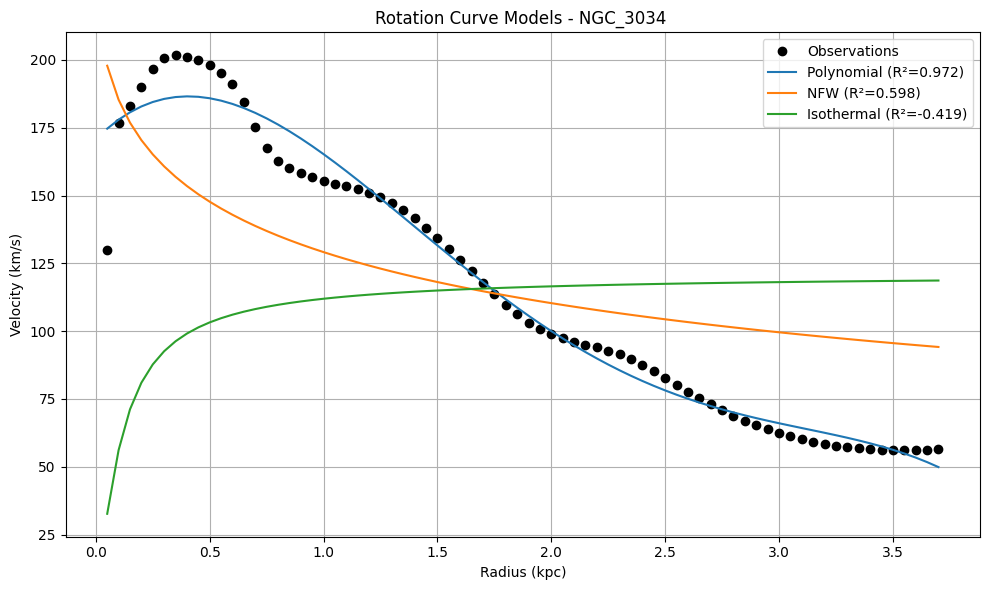

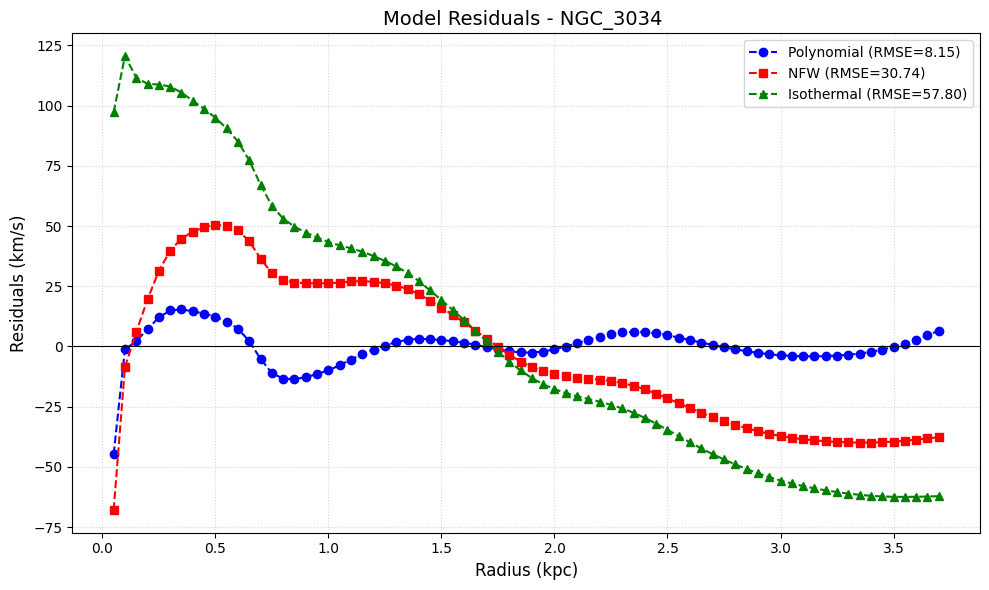


--- CONCLUSION ---
1. Best R²: Polynomial (0.972)
2. Lowest RMSE: Polynomial (8.15 km/s)
3. Best AIC: Polynomial (320.4)
4. Best BIC: Polynomial (331.9)

--- BEST OVERALL MODEL ---
Model Polynomial is the most suitable


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.constants import G as G_si
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
from scipy.signal import find_peaks
from scipy.optimize import differential_evolution

# ==================== Complete galaxy dictionary ====================
galaxies = {
    1: 'NGC_6674',
    2: 'NGC_0224',
    3: 'NGC_0100',
    4: 'NGC_1705',
    5: 'NGC_3198',
    6: 'NGC_3672',
    7: 'UGC_03691',
    8: 'NGC_4321',
    9: 'NGC_4565',
    10: 'NGC_5055',
    11: 'NGC_5907',
    12: 'NGC_7331',
    13: 'NGC_6951',
    14: 'IC_342',
    15: 'NGC_1003',
    16: 'NGC_2403',
    17: 'NGC_4062',
    18: 'NGC_4096',
    19: 'NGC_4631',
    20: 'DDO_170',
    21: 'ESO_444_C084',
    22: 'F563_1',
    23: 'F571_8',
    24: 'NGC_0055',
    25: 'NGC_3972',
    26: 'NGC_4214',
    27: 'NGC_4271',
    28: 'NGC_4559',
    29: 'UGC_00731',
    30: 'UGC_05986',
    31: 'UGC_06786',
    32: 'UGC_06983',
    33: 'UGC_07524',
    34: 'UGC_07603',
    35: 'UGC_08286',
    36: 'UGC_08490',
    37: 'UGC_11455',
    38: 'UGC_11914',
    39: 'UGC_12506',
    40: 'UGC_12632',
    41: 'UGC_12732',
    42: 'UGC_A444',
    43: 'UGC_08490',
    44: 'NGC_3031',
    45: 'Milky_Way',
    46: 'IC_342',
    47: 'NGC_3628',
    48: 'NGC_4258',
    49: 'NGC_4303',
    50: 'NGC_4527',
    51: 'NGC_4569',
    52: 'NGC_4736',
    53: 'MIlky_Way',
    54: 'NGC_3034 '
}


# Select galaxy
selected_galaxy = 54
galaxy_name = galaxies.get(selected_galaxy, f"Unknown Galaxy {selected_galaxy}")

# ==================== CONSTANTS ====================
G_kpc = 4.30091e-6   # (kpc (km/s)^2)/M_sun
M_sun = 1.98847e30   # kg
kpc_to_m = 3.086e19  # kpc to meters

# ==================== DATA PROCESSING ====================
def load_data(data_string):
    """Load and process observational data with error handling"""
    lines = data_string.strip().split('\n')
    r_kpc, v_rot_kms = [], []

    for line in lines:
        try:
            cols = line.split()
            if len(cols) >= 2:  # Take first two columns only
                r = float(cols[0])
                v = float(cols[1])
                if r >= 0 and v >= 0:  # Add basic physical validation
                    r_kpc.append(r)
                    v_rot_kms.append(v)
        except (ValueError, IndexError) as e:
            print(f"Warning: Could not parse line '{line}': {e}")

    if not r_kpc or not v_rot_kms:
        raise ValueError("No valid data loaded")
    
    return np.array(r_kpc), np.array(v_rot_kms)

# ==================== STATISTICAL FUNCTIONS ====================
def calculate_statistics(data, name):
    """Calculate statistics with NaN handling"""
    if len(data) == 0 or np.all(np.isnan(data)):
        print(f"\nNo valid data for {name}")
        return None

    clean_data = data[~np.isnan(data)]
    if len(clean_data) == 0:
        return None

    stats_results = {
        "Mean": np.nanmean(data),
        "Median": np.nanmedian(data),
        "Std Dev": np.nanstd(data),
        "Min": np.nanmin(data),
        "Max": np.nanmax(data),
        "Skewness": stats.skew(clean_data) if len(clean_data) > 2 else np.nan,
        "Kurtosis": stats.kurtosis(clean_data) if len(clean_data) > 3 else np.nan
    }

    print(f"\nStatistics for {name}:")
    for key, value in stats_results.items():
        if np.isnan(value):
            print(f"{key}: N/A")
        else:
            print(f"{key}: {value:.2f}")
    
    return stats_results

def model_metrics(observed, predicted, model_name):
    """Calculate model metrics with robust error handling"""
    valid_mask = ~np.isnan(predicted)
    if not np.any(valid_mask):
        print(f"\nWarning: {model_name} model produced all NaN predictions")
        return float('-inf'), float('inf'), np.full_like(observed, np.nan)

    observed_clean = observed[valid_mask]
    predicted_clean = predicted[valid_mask]

    try:
        r2 = r2_score(observed_clean, predicted_clean)
        mse = mean_squared_error(observed_clean, predicted_clean)
        rmse = np.sqrt(mse)
        residuals = observed_clean - predicted_clean

        print(f"\nMetrics for {model_name}:")
        print(f"R²: {r2:.4f}")
        print(f"RMSE: {rmse:.2f} km/s")
        print(f"MSE: {mse:.2f}")

        return r2, rmse, residuals
    except Exception as e:
        print(f"Error calculating metrics for {model_name}: {e}")
        return float('-inf'), float('inf'), np.full_like(observed_clean, np.nan)

def calculate_aic_bic(n, k, residuals):
    """Calculate AIC and BIC with error handling"""
    try:
        rss = np.sum(residuals**2)
        if rss <= 0 or n <= 0:
            return float('inf'), float('inf')
            
        aic = n * np.log(rss / n) + 2 * k
        bic = n * np.log(rss / n) + k * np.log(n)
        return aic, bic
    except Exception as e:
        print(f"Error calculating AIC/BIC: {e}")
        return float('inf'), float('inf')

# ==================== MODEL DEFINITIONS ====================
class PhysicallyConstrainedPolynomial:
    def __init__(self, r_kpc, v_rot_kms):
        self.r = r_kpc
        self.v_obs = v_rot_kms
        self.safe_r = np.where(r_kpc == 0, 1e-10, r_kpc)
        self.params = None
        self.v_pred = None

    def mass_model(self, r, c_neg1, c_0, *c_n):
        """Physical mass model:
        M(r) = c_{-1}*r + c_0 + Σ c_n/r^n
        """
        r = np.where(r == 0, 1e-10, r)
        terms = [c_neg1 * r, c_0]
        for n, c in enumerate(c_n, start=1):
            terms.append(c / (r**n))
        return np.sum(terms, axis=0)

    def velocity_model(self, r, *coefficients):
        """Velocity derived from mass:
        v_rot = sqrt(G*M(r)/r)
        """
        M_r = self.mass_model(r, *coefficients)
        return np.sqrt(G_kpc * M_r / r)

    def fit(self, n_terms=3):
        """Physical fit with constraints"""
        try:
            # Intelligent initial estimate
            M_obs = (self.v_obs**2) * self.safe_r / G_kpc
            
            # Build design matrix for fit
            X = []
            X.append(self.safe_r)       # c_{-1}*r term
            X.append(np.ones_like(self.safe_r))  # c_0 term
            
            # Add c_n/r^n terms
            for n in range(1, n_terms-1):
                X.append(1/(self.safe_r**n))
            
            X = np.column_stack(X)
            
            # Weighted linear fit
            params, _, _, _ = np.linalg.lstsq(X, M_obs, rcond=None)
            
            self.params = params
            self.v_pred = self.velocity_model(self.safe_r, *params)
            
            # Physical constraints
            self.v_pred = np.clip(self.v_pred, 0, 2*np.max(self.v_obs))
            return self.v_pred
            
        except Exception as e:
            print(f"Physical fit error: {e}")
            # Fallback: empirical polynomial
            coeffs = np.polyfit(self.safe_r, self.v_obs, deg=n_terms-1)
            self.v_pred = np.polyval(coeffs, self.safe_r)
            return self.v_pred

    def print_coefficients(self):
        """Show physical coefficients with correct % contributions"""
        if self.params is None:
            print("Model not fitted!")
            return
            
        # Calculate mass contributions at all radii
        terms = []
        terms.append(self.params[0] * self.safe_r)  # c_-1*r term
        terms.append(np.full_like(self.safe_r, self.params[1]))  # c_0 term
        
        for n in range(2, len(self.params)):
            terms.append(self.params[n] / (self.safe_r**(n-1)))  # c_n/r^(n-1) terms
        
        # Convert to numpy array and calculate absolute contributions
        term_arrays = np.array(terms)
        abs_contributions = np.abs(term_arrays)
        total_mass = np.sum(abs_contributions, axis=0)
        
        # Calculate percentage contributions at each radius
        with np.errstate(divide='ignore', invalid='ignore'):
            pct_contributions = 100 * abs_contributions / total_mass
        
        # Average across all radii, ignoring invalid values
        avg_pct = np.nanmean(pct_contributions, axis=1)
        
        print("\nPhysical model coefficients and contributions:")
        print(f"c_(-1) = {self.params[0]:.4e}  [linear r term] → {avg_pct[0]:.1f}% contribution")
        print(f"c_0    = {self.params[1]:.4e}  [constant term] → {avg_pct[1]:.1f}% contribution")
        
        for n in range(2, len(self.params)):
            print(f"c_{n-1}  = {self.params[n]:.4e}  [1/r^{n-1} term] → {avg_pct[n]:.1f}% contribution")
            
class EnhancedNFWModel:
    def __init__(self, r_kpc, v_rot_kms):
        self.r = r_kpc
        self.v_obs = v_rot_kms
        self.params = None
        self.pcov = None
        self.v_pred = None
        
    def velocity_profile(self, r, rho_s, r_s, v0=0, alpha=1):
        """Improved NFW profile with additional parameters"""
        safe_r = np.maximum(r, 1e-10)
        x = safe_r / r_s
        log_arg = np.maximum(1 + x**alpha, 1e-10)
        term = np.log(log_arg) - x**alpha/(1 + x**alpha)
        M = 4 * np.pi * rho_s * r_s**3 * term
        v_nfw = np.sqrt(np.maximum(G_kpc * M / safe_r, 0))
        return np.sqrt(v_nfw**2 + v0**2)
    
    def smart_initial_guess(self):
        """Intelligent parameter estimation"""
        try:
            peaks, _ = find_peaks(self.v_obs, height=np.mean(self.v_obs))
            if len(peaks) > 0:
                v_max = self.v_obs[peaks[0]]
                r_max = self.r[peaks[0]]
            else:
                v_max = np.max(self.v_obs)
                r_max = self.r[np.argmax(self.v_obs)]
            
            r_s_guess = r_max / 2.163
            rho_s_guess = (v_max**2)/(4*np.pi*G_kpc*r_s_guess**2) * 1.3
            return [rho_s_guess, r_s_guess, 10, 1]
        except:
            return [1e6, 10, 10, 1]
        
    def robust_fit(self, method='lm'):
        """Robust fitting with multiple strategies"""
        try:
            # First try with basic parameters
            p0 = self.smart_initial_guess()[:2]
            bounds = ([1e4, 0.01], [1e10, 100])
            
            self.params, self.pcov = curve_fit(
                lambda r, rho_s, r_s: self.velocity_profile(r, rho_s, r_s),
                self.r,
                self.v_obs,
                p0=p0,
                bounds=bounds,
                method=method,
                max_nfev=10000
            )
            
            # Extend parameters with defaults
            self.params = np.append(self.params, [10, 1])
            self.v_pred = self.velocity_profile(self.r, *self.params)
            return self.v_pred
            
        except Exception as e:
            print(f"Basic NFW fit failed: {e}")
            try:
                # Try with all parameters
                p0_extended = self.smart_initial_guess()
                bounds_extended = ([1e4, 0.01, 0, 0.5], [1e10, 100, 50, 1.5])
                
                self.params, self.pcov = curve_fit(
                    self.velocity_profile,
                    self.r,
                    self.v_obs,
                    p0=p0_extended,
                    bounds=bounds_extended,
                    method='trf',
                    max_nfev=10000
                )
                self.v_pred = self.velocity_profile(self.r, *self.params)
                return self.v_pred
                
            except Exception as e:
                print(f"Full NFW fit failed: {e}")
                print("Trying genetic algorithm...")
                try:
                    bounds = [(1e4, 1e10), (0.01, 100), (0, 50), (0.5, 1.5)]
                    result = differential_evolution(
                        lambda params: np.sum((self.v_obs - self.velocity_profile(self.r, *params))**2),
                        bounds=bounds,
                        maxiter=100,
                        popsize=15,
                        tol=0.1
                    )
                    self.params = result.x
                    self.v_pred = self.velocity_profile(self.r, *result.x)
                    return self.v_pred
                except Exception as e:
                    print(f"Genetic algorithm failed: {e}")
                    self.v_pred = np.full_like(self.v_obs, np.nan)
                    return self.v_pred

class IsothermalModel:
    def __init__(self, r_kpc, v_rot_kms):
        self.r = r_kpc
        self.v_obs = v_rot_kms
        self.params = None
        self.pcov = None
        self.v_pred = None

    def velocity_profile(self, r, v_inf, r_c):
        """Isothermal profile with safety checks"""
        safe_r = np.maximum(r, 1e-10)
        term = 1 - (r_c / safe_r) * np.arctan(safe_r / r_c)
        return v_inf * np.sqrt(np.maximum(term, 0))

    def fit(self):
        """Fit isothermal model with error handling"""
        try:
            # Get reasonable initial guesses
            v0_guess = np.median(self.v_obs[-5:])  # Use last few points for v_inf estimate
            r0_guess = np.median(self.r)/2  # Median radius as initial guess
            
            self.params, self.pcov = curve_fit(
                self.velocity_profile,
                self.r,
                self.v_obs,
                p0=[v0_guess, r0_guess],
                bounds=([50, 0.1], [300, 50]),
                maxfev=5000
            )
            self.v_pred = self.velocity_profile(self.r, *self.params)
            return self.v_pred
        except Exception as e:
            print(f"Isothermal fitting failed: {e}")
            self.v_pred = np.full_like(self.v_obs, np.nan)
            return self.v_pred

    def calculate_rho_0(self, v_inf, r_c):
        """Calculate ρ_0 with safety checks"""
        try:
            denom = 4 * np.pi * G_kpc * r_c**2
            if denom <= 0:
                raise ValueError("Negative denominator in ρ_0 calculation")
            return (v_inf**2) / denom
        except Exception as e:
            print(f"Error calculating ρ_0: {e}")
            return np.nan

# ==================== MAIN EXECUTION ====================
if __name__ == "__main__":
    # Load data
    data_string = """ 0.05000   129.91779
     0.10000   176.76389
     0.15000   182.87331
     0.20000   190.01215
     0.25000   196.52267
     0.30000   200.55829
     0.35000   201.69310
     0.40000   201.13620
     0.45000   200.05144
     0.50000   198.21503
     0.55000   195.29678
     0.60000   191.14877
     0.65000   184.42789
     0.70000   175.27180
     0.75000   167.39085
     0.80000   162.78957
     0.85000   160.11481
     0.90000   158.26347
     0.95000   156.75000
     1.00000   155.36005
     1.05000   154.34653
     1.10000   153.53966
     1.15000   152.46002
     1.20000   151.02031
     1.25000   149.32091
     1.30000   147.30666
     1.35000   144.80830
     1.40000   141.73651
     1.45000   138.02545
     1.50000   134.25027
     1.55000   130.35773
     1.60000   126.31830
     1.65000   122.14217
     1.70000   117.89532
     1.75000   113.70509
     1.80000   109.74356
     1.85000   106.18648
     1.90000   103.16184
     1.95000   100.71314
     2.00000    98.79511
     2.05000    97.29974
     2.10000    96.09148
     2.15000    95.03068
     2.20000    93.98042
     2.25000    92.80896
     2.30000    91.40158
     2.35000    89.68330
     2.40000    87.64010
     2.45000    85.32285
     2.50000    82.82868
     2.55000    80.26911
     2.60000    77.74074
     2.65000    75.30970
     2.70000    73.01094
     2.75000    70.85716
     2.80000    68.85078
     2.85000    66.99417
     2.90000    65.29513
     2.95000    63.76552
     3.00000    62.41374
     3.05000    61.23616
     3.10000    60.21465
     3.15000    59.32341
     3.20000    58.53999
     3.25000    57.85346
     3.30000    57.26593
     3.35000    56.78814
     3.40000    56.43170
     3.45000    56.20149
     3.50000    56.09203
     3.55000    56.08913
     3.60000    56.17309
     3.65000    56.31981
     3.70000    56.50000 """

    try:
        r_kpc, v_rot_kms = load_data(data_string)
        print(f"Galaxy selected: {galaxy_name}")
        print(f"Number of data points: {len(r_kpc)}")
        
        # Calculate statistics
        r_stats = calculate_statistics(r_kpc, "Radius (kpc)")
        v_stats = calculate_statistics(v_rot_kms, "Velocity (km/s)")
        
        # Initialize models
        models = {
            "Polynomial": PhysicallyConstrainedPolynomial(r_kpc, v_rot_kms),
            "NFW": EnhancedNFWModel(r_kpc, v_rot_kms),
            "Isothermal": IsothermalModel(r_kpc, v_rot_kms)
        }

        # Fit models
        try:
            n_terms = int(input("Enter number of terms for polynomial model (2-10, default=3): ") or 3)
            if n_terms < 2 or n_terms > 10:
                raise ValueError("Number of terms must be between 2 and 10")
        except ValueError as e:
            print(f"Invalid input: {e}. Using default n_terms=3")
            n_terms = 3

        print("\nFitting models...")
        v_poly = models["Polynomial"].fit(n_terms)
        v_nfw = models["NFW"].robust_fit()
        v_iso = models["Isothermal"].fit()

        # Calculate metrics
        metrics = {
            "Polynomial": model_metrics(v_rot_kms, v_poly, "Polynomial Model"),
            "NFW": model_metrics(v_rot_kms, v_nfw, "NFW Model"),
            "Isothermal": model_metrics(v_rot_kms, v_iso, "Isothermal Model")
        }
        
        # Calculate AIC/BIC
        n = len(v_rot_kms)
        aic_bic = {}
        for name, model in models.items():
            if model.v_pred is None or np.all(np.isnan(model.v_pred)):
                aic_bic[name] = (float('inf'), float('inf'))
                continue
                
            _, _, residuals = metrics[name]
            if name == "Polynomial":
                k = n_terms
            elif name == "NFW":
                k = len(model.params) if hasattr(model, 'params') and model.params is not None else 4
            else:
                k = 2
                
            aic, bic = calculate_aic_bic(len(residuals), k, residuals)
            aic_bic[name] = (aic, bic)
            print(f"{name} Model - AIC: {aic:.1f}, BIC: {bic:.1f}")

        # Density calculations
        if hasattr(models["NFW"], 'params') and models["NFW"].params is not None:
            try:
                rho_s, r_s, v0, alpha = models["NFW"].params
                print(f"\n NFW Parameters:")
                print(f"ρ_s = {rho_s:.2e} M☉/kpc³")
                print(f"r_s = {r_s:.2f} kpc")
                print(f"v0 = {v0:.2f} km/s")
                print(f"α = {alpha:.2f}")
            except Exception as e:
                print(f"\nError displaying NFW parameters: {e}")
        
        if hasattr(models["Isothermal"], 'params') and models["Isothermal"].params is not None:
            try:
                v_inf, r_c = models["Isothermal"].params
                rho_0 = models["Isothermal"].calculate_rho_0(v_inf, r_c)
                print(f"\nIsothermal Density: ρ_0 = {rho_0:.2e} M☉/kpc³ (r_c = {r_c:.2f} kpc)")
            except Exception as e:
                print(f"\nCould not calculate Isothermal density: {e}")

        # Print polynomial coefficients using the new method
        if hasattr(models["Polynomial"], 'print_coefficients'):
            models["Polynomial"].print_coefficients()
        
        # Plot rotation curve
        plt.figure(figsize=(10, 6))
        plt.plot(r_kpc, v_rot_kms, 'ko', label='Observations')
        for name, model in models.items():
            if model.v_pred is not None and not np.all(np.isnan(model.v_pred)):
                plt.plot(r_kpc, model.v_pred, label=f"{name} (R²={metrics[name][0]:.3f})")
        plt.xlabel('Radius (kpc)')
        plt.ylabel('Velocity (km/s)')
        plt.title(f'Rotation Curve Models - {galaxy_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'{galaxy_name.replace(" ", "_")}_rotation_curve.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Plot residuals with dashed lines
        plt.figure(figsize=(10, 6))
        # Define styles for each model
        styles = {
            "Polynomial": {'marker': 'o', 'linestyle': '--', 'color': 'blue'},
            "NFW": {'marker': 's', 'linestyle': '--', 'color': 'red'},
            "Isothermal": {'marker': '^', 'linestyle': '--', 'color': 'green'}
        }
        
        for name, model in models.items():
            if model.v_pred is not None and not np.all(np.isnan(model.v_pred)):
                residuals = v_rot_kms - model.v_pred
                plt.plot(r_kpc, residuals, 
                         label=f"{name} (RMSE={metrics[name][1]:.2f})",
                         **styles.get(name, {'marker': 'o', 'linestyle': '--'}))
                
        plt.axhline(0, color='k', linestyle='-', linewidth=0.8)
        plt.xlabel('Radius (kpc)', fontsize=12)
        plt.ylabel('Residuals (km/s)', fontsize=12)
        plt.title(f'Model Residuals - {galaxy_name}', fontsize=14)
        plt.legend(fontsize=10, loc='upper right')
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.tight_layout()
        plt.savefig(f'{galaxy_name.replace(" ", "_")}_residuals_plot.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Conclusion
        print("\n--- CONCLUSION ---")
        active_metrics = {
            name: {
                'R2': metrics[name][0],
                'RMSE': metrics[name][1],
                'AIC': aic_bic[name][0],
                'BIC': aic_bic[name][1]
            }
            for name in models
            if not np.isinf(metrics[name][0])  # Only include models that were successfully fitted
        }

        if not active_metrics:
            print("No model was successfully fitted!")
        else:
            # Find best models for each metric
            best_R2 = max(active_metrics.keys(), key=lambda x: active_metrics[x]['R2'])
            best_RMSE = min(active_metrics.keys(), key=lambda x: active_metrics[x]['RMSE'])
            best_AIC = min(active_metrics.keys(), key=lambda x: active_metrics[x]['AIC'])
            best_BIC = min(active_metrics.keys(), key=lambda x: active_metrics[x]['BIC'])
            
            print(f"1. Best R²: {best_R2} ({active_metrics[best_R2]['R2']:.3f})")
            print(f"2. Lowest RMSE: {best_RMSE} ({active_metrics[best_RMSE]['RMSE']:.2f} km/s)")
            print(f"3. Best AIC: {best_AIC} ({active_metrics[best_AIC]['AIC']:.1f})")
            print(f"4. Best BIC: {best_BIC} ({active_metrics[best_BIC]['BIC']:.1f})")

            # Score models based on how often they appear as best
            scores = {model: 0 for model in active_metrics}
            for model in active_metrics:
                if model == best_R2: scores[model] += 1
                if model == best_RMSE: scores[model] += 1
                if model == best_AIC: scores[model] += 1
                if model == best_BIC: scores[model] += 1

            max_score = max(scores.values())
            best_models = [m for m, s in scores.items() if s == max_score]

            print("\n--- BEST OVERALL MODEL ---")
            if len(best_models) == 1:
                print(f"Model {best_models[0]} is the most suitable")
            else:
                # If tie, use R² as tie-breaker
                best_overall = max(best_models, key=lambda x: active_metrics[x]['R2'])
                print(f"Model {best_overall} selected by tie-breaker (best R²)")

    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()